# 1DCNN code for damage localization

## Importing APIs

In [1]:
#imports
import os
#import zipfile
%matplotlib inline
import random 
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Conv1D, MaxPooling1D, Dropout, Lambda, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.utils import to_categorical,plot_model
from sklearn.metrics import confusion_matrix, classification_report
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import *
from sklearn.preprocessing import MinMaxScaler

## Callbacks

## Importing data

In [2]:
### Dataset
#dataframe = pd.read_csv('data_1multiclass_balanced_600000.csv')
dataframe=pd.read_csv('datos_daño1000m_d1_t1.csv')
dataframe.head()

,Unnamed: 0,num_analysis,t,F_fem,F,d1,d2,d3,d4,d5,...,label5,label6,alfa1,alfa2,alfa3,alfa4,alfa5,alfa6,beta,label
0,0,0,0,349.371761,363.007142,0.005261,0.010726,0.016223,0.021746,0.027284,...,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
1,1,1,0,349.371761,363.007142,0.005261,0.010726,0.016223,0.021746,0.027284,...,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
2,2,2,0,349.371761,363.007142,0.005261,0.010726,0.016223,0.021746,0.027284,...,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
3,3,3,0,349.371761,363.007142,0.005261,0.010726,0.016223,0.021746,0.027284,...,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
4,4,4,0,349.371761,363.007142,0.005261,0.010726,0.016223,0.021746,0.027284,...,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0


In [3]:
dataframe=dataframe.drop(['Unnamed: 0', 'num_analysis','t','F_fem','F','alfa1','alfa2','alfa3','alfa4','alfa5','alfa6','beta', 'label'], axis=1)
dataframe.head()

,d1,d2,d3,d4,d5,d6,label1,label2,label3,label4,label5,label6
0,0.005261,0.010726,0.016223,0.021746,0.027284,0.032749,0,0,0,0,0,0
1,0.005261,0.010726,0.016223,0.021746,0.027284,0.032749,0,0,0,0,0,0
2,0.005261,0.010726,0.016223,0.021746,0.027284,0.032749,0,0,0,0,0,0
3,0.005261,0.010726,0.016223,0.021746,0.027284,0.032749,0,0,0,0,0,0
4,0.005261,0.010726,0.016223,0.021746,0.027284,0.032749,0,0,0,0,0,0


In [4]:
dataframe.tail()

,d1,d2,d3,d4,d5,d6,label1,label2,label3,label4,label5,label6
605995,0.001834,0.006394,0.008311,0.010236,0.012166,0.014072,0,1,0,0,0,0
605996,0.001834,0.003739,0.008311,0.010236,0.012166,0.014072,0,0,1,0,0,0
605997,0.001834,0.003739,0.005656,0.010236,0.012166,0.014072,0,0,0,1,0,0
605998,0.001834,0.003739,0.005656,0.007581,0.012166,0.014072,0,0,0,0,1,0
605999,0.001834,0.003739,0.005656,0.007581,0.009511,0.014072,0,0,0,0,0,1


In [5]:
dataset=dataframe.to_numpy()

In [6]:
X = dataset[:,0:6].astype(float)
print(X)

[[0.00526136 0.01072574 0.01622348 0.02174558 0.0272835  0.03274877]
 [0.00526136 0.01072574 0.01622348 0.02174558 0.0272835  0.03274877]
 [0.00526136 0.01072574 0.01622348 0.02174558 0.0272835  0.03274877]
 ...
 [0.00183416 0.00373909 0.00565564 0.01023577 0.01216635 0.01407159]
 [0.00183416 0.00373909 0.00565565 0.0075807  0.01216634 0.01407159]
 [0.00183416 0.00373909 0.00565565 0.00758071 0.00951137 0.01407167]]


In [7]:
Y = dataset[:,6:12].astype(int)
print(Y)
# 0 es sano, 1 es daño

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


In [8]:
dataset = shuffle(dataset)

In [9]:
# load DATEST de Test
dataTest = pd.read_excel("datos_TEST.xlsx") 
dataTest= shuffle(dataTest)
dataTest['d1'] = dataTest['d1'] / 1000
dataTest['d2'] = dataTest['d2'] / 1000
dataTest['d3'] = dataTest['d3'] / 1000
dataTest['d4'] = dataTest['d4'] / 1000
dataTest['d5'] = dataTest['d5'] / 1000
dataTest['d6'] = dataTest['d6'] / 1000
dataTest.head()

,t,F,d1,d2,d3,d4,d5,d6,label1,label2,...,label5,label6,alfa1,alfa2,alfa3,alfa4,alfa5,alfa6,beta,label
1724,100,94.192820,1.341338e-06,0.002734,0.006078,0.007486,0.008897,0.010291,0,0,...,0,0,1.0,1.0,0.4,1.0,1.0,1.0,1,1
847,66,97.727331,1.449616e-06,0.003888,0.005403,0.006924,0.008450,0.009956,0,1,...,0,0,1.0,0.6,1.0,1.0,1.0,1.0,1,1
481,0,348.776685,4.956269e-06,0.010104,0.015283,0.020485,0.025701,0.030850,0,0,...,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1,0
1728,100,186.771367,7.013906e-06,0.010195,0.013395,0.016607,0.019827,0.022944,1,0,...,0,0,0.4,1.0,1.0,1.0,1.0,1.0,1,1
370,0,39.937987,6.047090e-07,0.001233,0.001865,0.002499,0.003136,0.003764,0,0,...,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1,0


In [10]:
dataTest_values = dataTest.values
X_test0 = dataTest_values[:,[2,3,4,5,6,7]] # Fuerza (N) y desp (nm)
y_test0 = dataTest_values[:,[8,9,10,11,12,13]] #t 
print(X_test0[0])
print(y_test0[0])

[1.34133799e-06 2.73442592e-03 6.07770666e-03 7.48553235e-03
 8.89737934e-03 1.02907023e-02]
[0. 0. 1. 0. 0. 0.]


In [11]:
# Vuelvo al Dataset de Training
dataset = shuffle(dataset)
scaler = MinMaxScaler(feature_range=(0,1))

X_scaled = scaler.fit_transform(X)
X=X_scaled
X_test0 = scaler.transform(X_test0)

rows,columns=X.shape
rows0,columns0=X_test0.shape

X=X.reshape(rows,columns,1)

X_test0=X_test0.reshape(rows0,columns0,1)

# 0 es sano, 1 es daño

In [12]:
print(X[1])

[[0.3508662 ]
 [0.49208753]
 [0.5665244 ]
 [0.61246294]
 [0.64364564]
 [0.66761767]]


In [13]:
print(Y[1])

[0 0 0 0 0 0]


## Splitting testing and test set

In [14]:
N=rows
split1=int(0.8*N)
split2=int(0.9*N)

# Split the dataset into training and testing sets
X_train, X_valid, X_test = X[:split1], X[split1:split2], X[split2:]
y_train, y_valid, y_test = Y[:split1], Y[split1:split2], Y[split2:]


In [15]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(484800, 6, 1) (484800, 6)
(60600, 6, 1) (60600, 6)
(60600, 6, 1) (60600, 6)


In [16]:
X_valid

array([[[0.47610772],
        [0.51451071],
        [0.53475274],
        [0.54724514],
        [0.55572841],
        [0.56224661]],

       [[0.24807353],
        [0.49996044],
        [0.51627487],
        [0.52636971],
        [0.53325973],
        [0.539588  ]],

       [[0.2480758 ],
        [0.34792351],
        [0.5162739 ],
        [0.52636963],
        [0.53325966],
        [0.53958792]],

       ...,

       [[0.12371706],
        [0.17351237],
        [0.1997588 ],
        [0.27515349],
        [0.27653559],
        [0.27825205]],

       [[0.12371706],
        [0.17351237],
        [0.19975916],
        [0.21595714],
        [0.27653544],
        [0.27825203]],

       [[0.12371706],
        [0.17351237],
        [0.19975916],
        [0.21595731],
        [0.22695435],
        [0.27825359]]])

In [17]:
y_valid

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]])

## Model Architecture

In [18]:
# define model architecture : 1DCNN-classification
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from keras.models import Sequential
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model

Inp = Input(shape=(6,1))
#tf.keras.Input(shape=None,
#Inp = Input(shape=(X.shape[1],1))

x1 = Sequential()

x1 = Conv1D(filters=32, kernel_size=3, input_shape=(6,1))(Inp) #32
#x1 = MaxPooling1D(pool_size=2)(x1)

x1 = Conv1D(filters=32, kernel_size=3, activation='relu')(x1) #32
#x1 = MaxPooling1D(pool_size=2)(x1)

x1 = Conv1D(filters=32, kernel_size=2, activation='relu')(x1)
#x1 = MaxPooling1D(pool_size=2)(x1)

#x1 = Conv1D(filters=128, kernel_size=3, activation='relu')(x1)
#x1 = MaxPooling1D(pool_size=2)(x1)

#x1 = Conv1D(filters=256, kernel_size=3, activation='relu')(x1)
#x1 = MaxPooling1D(pool_size=2)(x1)

x1 = Flatten()(x1)

cnn1 = Model(Inp,x1)

In [19]:
from keras.layers import concatenate
#x = concatenate([cnn1.output,cnn2.output])
x = cnn1.output
#---------------------------------
x = Dense(128, activation='relu')((x)) #63
x = Dense(64, activation='relu')(x) #54
#x = Dense(16, activation='relu')(x) #36
#x = Dense(64, activation='relu')(x) #24
#x = Dense(64, activation='relu')(x) #12
#x = Dense(64, activation='relu')(x) #12
x = Dropout(0.25)(x)
x = Dense(6, activation='softmax')(x)
#---------------------------------
model = Model(inputs = Inp, outputs=x)

In [20]:
# summary of the model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 conv1d (Conv1D)             (None, 4, 32)             128       
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 32)             3104      
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 32)             2080      
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 128)               4224      
                                                                 
 dense_1 (Dense)             (None, 64)                8256

In [21]:
# Functions for recall, precision and f1 score
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Choose Hyperparameters

In [23]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['acc', precision_m, recall_m])

## Training

In [24]:
# train the model    #no poner más de 100 epochs, el rendimiento decrece
bsize = 128 #64
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=200, batch_size = bsize, verbose=2, shuffle = False)
#model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_val, y_val), callbacks=[reduce_lr])
#history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=250, batch_size = bsize, verbose=2, shuffle = True, callbacks = [lr_schedule_2])
#model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_val, y_val), callbacks=[reduce_lr])

Epoch 1/200
3788/3788 - 12s - loss: 1.7551 - acc: 0.2562 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 1.6713 - val_acc: 0.5353 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00 - 12s/epoch - 3ms/step
Epoch 2/200
3788/3788 - 10s - loss: 1.5980 - acc: 0.3931 - precision_m: 0.3457 - recall_m: 0.0339 - val_loss: 1.1399 - val_acc: 0.7722 - val_precision_m: 1.0000 - val_recall_m: 0.1852 - 10s/epoch - 3ms/step
Epoch 3/200
3788/3788 - 11s - loss: 1.2991 - acc: 0.5210 - precision_m: 0.7225 - recall_m: 0.1533 - val_loss: 0.6898 - val_acc: 0.9597 - val_precision_m: 1.0000 - val_recall_m: 0.5260 - 11s/epoch - 3ms/step
Epoch 4/200
3788/3788 - 11s - loss: 1.0599 - acc: 0.6362 - precision_m: 0.8531 - recall_m: 0.2920 - val_loss: 0.4153 - val_acc: 0.9716 - val_precision_m: 1.0000 - val_recall_m: 0.7886 - 11s/epoch - 3ms/step
Epoch 5/200
3788/3788 - 11s - loss: 0.8840 - acc: 0.7232 - precision_m: 0.8742 - recall_m: 0.4256 - val_loss: 0.2639 - val_acc: 0.9758 - val_precision_m: 1.

Epoch 41/200
3788/3788 - 12s - loss: 0.1731 - acc: 0.9402 - precision_m: 0.9614 - recall_m: 0.9078 - val_loss: 0.0242 - val_acc: 0.9948 - val_precision_m: 0.9972 - val_recall_m: 0.9928 - 12s/epoch - 3ms/step
Epoch 42/200
3788/3788 - 11s - loss: 0.1717 - acc: 0.9407 - precision_m: 0.9611 - recall_m: 0.9091 - val_loss: 0.0238 - val_acc: 0.9949 - val_precision_m: 0.9971 - val_recall_m: 0.9929 - 11s/epoch - 3ms/step
Epoch 43/200
3788/3788 - 11s - loss: 0.1689 - acc: 0.9414 - precision_m: 0.9614 - recall_m: 0.9105 - val_loss: 0.0233 - val_acc: 0.9950 - val_precision_m: 0.9971 - val_recall_m: 0.9930 - 11s/epoch - 3ms/step
Epoch 44/200
3788/3788 - 11s - loss: 0.1675 - acc: 0.9415 - precision_m: 0.9617 - recall_m: 0.9118 - val_loss: 0.0227 - val_acc: 0.9950 - val_precision_m: 0.9971 - val_recall_m: 0.9932 - 11s/epoch - 3ms/step
Epoch 45/200
3788/3788 - 11s - loss: 0.1653 - acc: 0.9417 - precision_m: 0.9613 - recall_m: 0.9129 - val_loss: 0.0224 - val_acc: 0.9951 - val_precision_m: 0.9970 - val_

Epoch 81/200
3788/3788 - 10s - loss: 0.1687 - acc: 0.9381 - precision_m: 0.9507 - recall_m: 0.9247 - val_loss: 0.0123 - val_acc: 0.9967 - val_precision_m: 0.9976 - val_recall_m: 0.9960 - 10s/epoch - 3ms/step
Epoch 82/200
3788/3788 - 11s - loss: 0.1688 - acc: 0.9381 - precision_m: 0.9508 - recall_m: 0.9250 - val_loss: 0.0122 - val_acc: 0.9968 - val_precision_m: 0.9976 - val_recall_m: 0.9960 - 11s/epoch - 3ms/step
Epoch 83/200
3788/3788 - 10s - loss: 0.1728 - acc: 0.9373 - precision_m: 0.9497 - recall_m: 0.9241 - val_loss: 0.0120 - val_acc: 0.9968 - val_precision_m: 0.9976 - val_recall_m: 0.9960 - 10s/epoch - 3ms/step
Epoch 84/200
3788/3788 - 11s - loss: 0.1733 - acc: 0.9370 - precision_m: 0.9494 - recall_m: 0.9244 - val_loss: 0.0118 - val_acc: 0.9969 - val_precision_m: 0.9976 - val_recall_m: 0.9961 - 11s/epoch - 3ms/step
Epoch 85/200
3788/3788 - 10s - loss: 0.1767 - acc: 0.9364 - precision_m: 0.9484 - recall_m: 0.9240 - val_loss: 0.0117 - val_acc: 0.9969 - val_precision_m: 0.9976 - val_

Epoch 121/200
3788/3788 - 12s - loss: 0.3867 - acc: 0.9141 - precision_m: 0.9217 - recall_m: 0.9087 - val_loss: 0.0077 - val_acc: 0.9974 - val_precision_m: 0.9977 - val_recall_m: 0.9969 - 12s/epoch - 3ms/step
Epoch 122/200
3788/3788 - 12s - loss: 0.3961 - acc: 0.9137 - precision_m: 0.9210 - recall_m: 0.9081 - val_loss: 0.0076 - val_acc: 0.9975 - val_precision_m: 0.9977 - val_recall_m: 0.9970 - 12s/epoch - 3ms/step
Epoch 123/200
3788/3788 - 11s - loss: 0.4095 - acc: 0.9125 - precision_m: 0.9197 - recall_m: 0.9071 - val_loss: 0.0077 - val_acc: 0.9973 - val_precision_m: 0.9976 - val_recall_m: 0.9969 - 11s/epoch - 3ms/step
Epoch 124/200
3788/3788 - 13s - loss: 0.4211 - acc: 0.9110 - precision_m: 0.9181 - recall_m: 0.9057 - val_loss: 0.0075 - val_acc: 0.9974 - val_precision_m: 0.9978 - val_recall_m: 0.9970 - 13s/epoch - 3ms/step
Epoch 125/200
3788/3788 - 12s - loss: 0.4314 - acc: 0.9112 - precision_m: 0.9181 - recall_m: 0.9061 - val_loss: 0.0075 - val_acc: 0.9974 - val_precision_m: 0.9976 -

Epoch 161/200
3788/3788 - 11s - loss: 1.2083 - acc: 0.8850 - precision_m: 0.8867 - recall_m: 0.8832 - val_loss: 0.0141 - val_acc: 0.9958 - val_precision_m: 0.9960 - val_recall_m: 0.9956 - 11s/epoch - 3ms/step
Epoch 162/200
3788/3788 - 13s - loss: 1.1762 - acc: 0.8863 - precision_m: 0.8883 - recall_m: 0.8850 - val_loss: 0.0139 - val_acc: 0.9959 - val_precision_m: 0.9960 - val_recall_m: 0.9957 - 13s/epoch - 4ms/step
Epoch 163/200
3788/3788 - 15s - loss: 1.2836 - acc: 0.8828 - precision_m: 0.8842 - recall_m: 0.8809 - val_loss: 0.0144 - val_acc: 0.9957 - val_precision_m: 0.9960 - val_recall_m: 0.9955 - 15s/epoch - 4ms/step
Epoch 164/200
3788/3788 - 14s - loss: 1.2979 - acc: 0.8827 - precision_m: 0.8841 - recall_m: 0.8807 - val_loss: 0.0151 - val_acc: 0.9956 - val_precision_m: 0.9959 - val_recall_m: 0.9955 - 14s/epoch - 4ms/step
Epoch 165/200
3788/3788 - 14s - loss: 1.2898 - acc: 0.8834 - precision_m: 0.8847 - recall_m: 0.8816 - val_loss: 0.0150 - val_acc: 0.9954 - val_precision_m: 0.9960 -

## Plot Accuracy and Loss

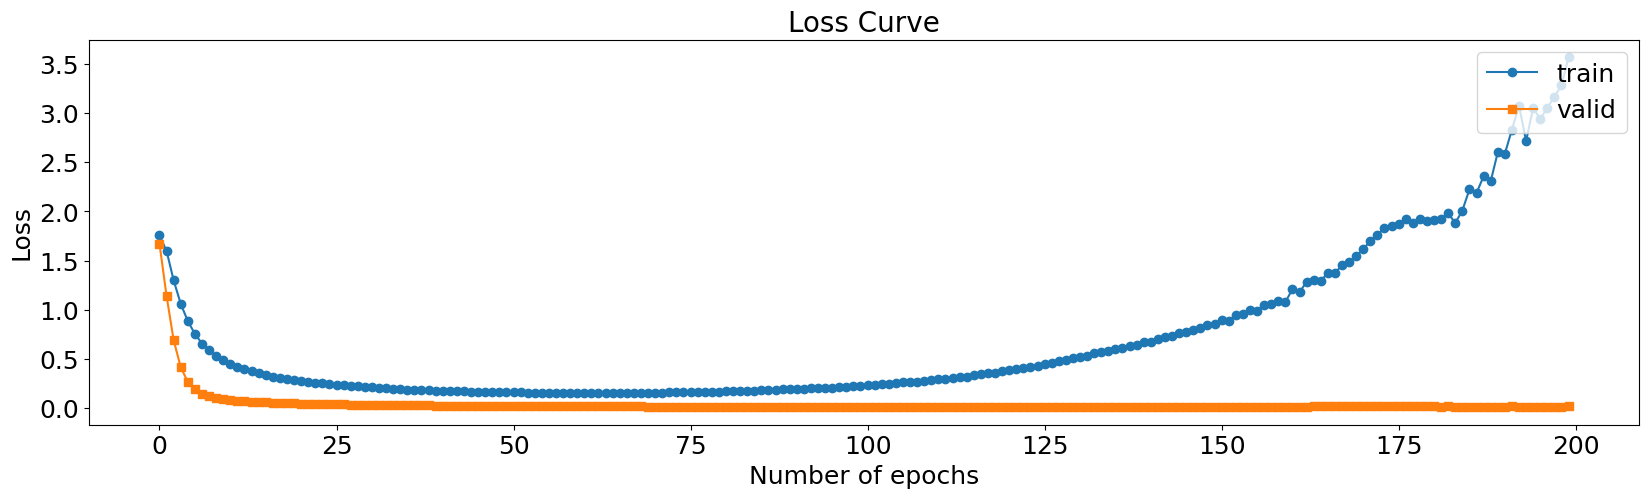

In [25]:
#---Summarize history for loss
plt.figure(figsize=(20,5))
plt.plot(history.history['loss'],'-o')
plt.plot(history.history['val_loss'],'-s')
plt.title('Loss Curve',fontsize=20)
plt.ylabel('Loss',fontsize=18)
#plt.grid()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of epochs',fontsize=18)
plt.legend(['train', 'valid'], loc='upper right',fontsize=18)
#plt.axis([0,1000,0,500])
plt.show()

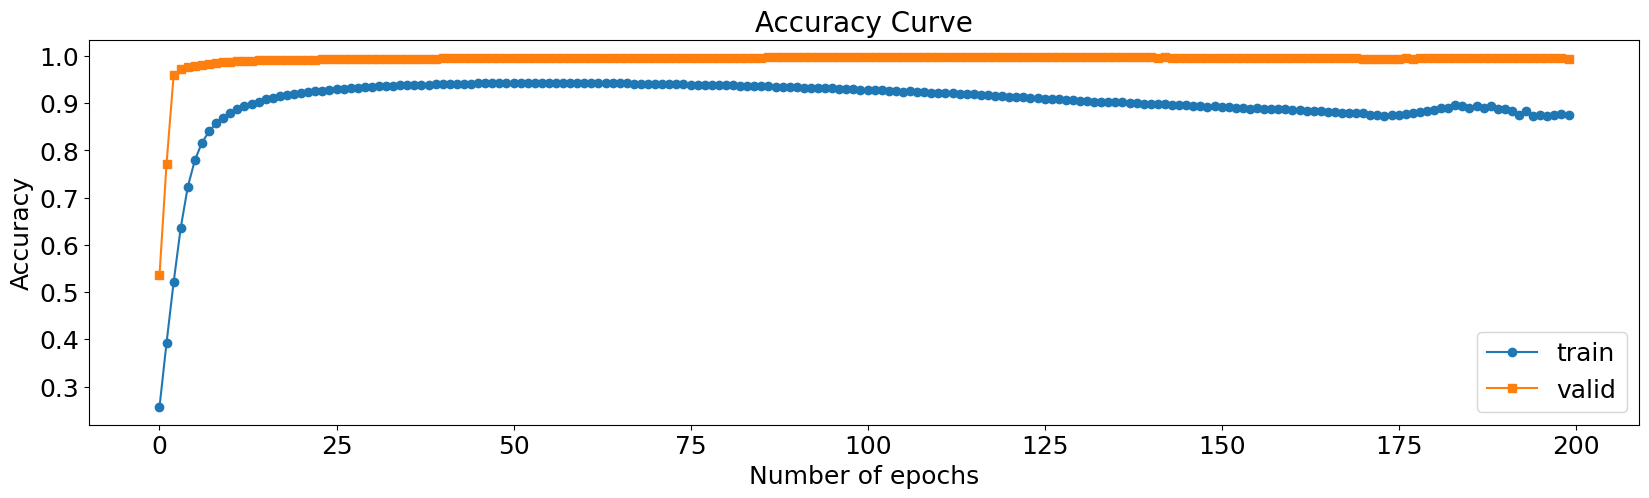

In [26]:
#---Summarize history for accuracy---
plt.figure(figsize=(20,5))
plt.plot(history.history['acc'],'-o')
plt.plot(history.history['val_acc'],'-s')
plt.title('Accuracy Curve',fontsize=20)
plt.ylabel('Accuracy',fontsize=18)
#plt.grid()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of epochs',fontsize=18)
plt.legend(['train', 'valid'], loc='lower right',fontsize=18)
#plt.axis([0,1000,0,500])
plt.show()

### Predictions

In [26]:
from sklearn.utils.multiclass import unique_labels
import itertools
import matplotlib.pyplot as plt
from keras.utils import to_categorical

fig = plt.gcf()


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i,j],
      horizontalalignment = 'center',
      color = "white" if cm[i,j] > thresh else "black")

    fig.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted label')
   

<Figure size 640x480 with 0 Axes>

In [27]:
y_predicted = model.predict(X_valid, verbose = 2)
y_actual = y_valid

y_predict = model.predict(X_valid, verbose = 2)
y_predict = np.argmax(y_predict, axis=1)

y_act = np.argmax(y_valid, axis=1)  # converting one hot representation back to numerical data

cm = confusion_matrix(y_act, y_predict)

1894/1894 - 2s - 2s/epoch - 903us/step
1894/1894 - 2s - 2s/epoch - 1ms/step


In [28]:
y_predicted.shape

(60600, 6)

In [29]:
y_act.shape

(60600,)

Confusion matrix, without normalization
[[10065     0     0     0     0    35]
 [    0 10078     0     0     0    22]
 [    0     0 10091     0     0     9]
 [    0     0     0 10083     0    17]
 [    0     0     0     0 10055    45]
 [    0     0     0     0     0 10100]]


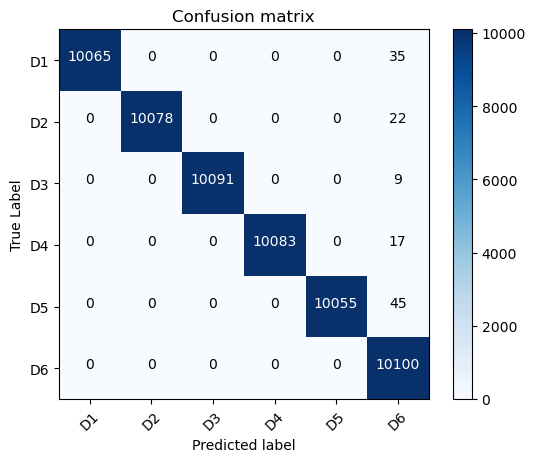

In [30]:
# Plot Non-Normalized confusion matrix
cm_labels = ['D1','D2','D3','D4','D5','D6']
plot_confusion_matrix(cm, classes=cm_labels, title='Confusion matrix')

Normalized confusion matrix
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


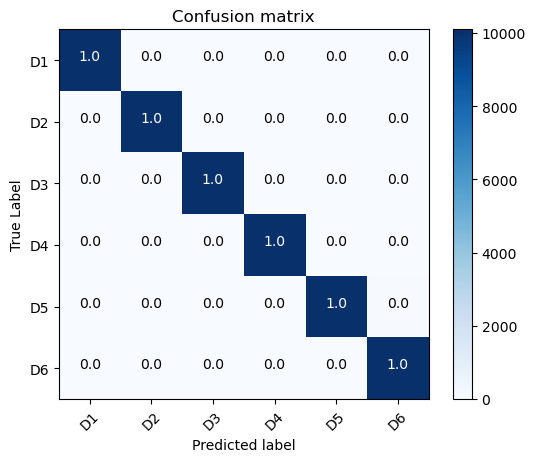

In [31]:
# Plot Normalized confusion matrix
plot_confusion_matrix(cm, classes=cm_labels, normalize = True, title='Confusion matrix')

In [32]:
# Classification Report
print('Classification Report')
print(classification_report(y_act, y_predict, target_names = cm_labels))

Classification Report
              precision    recall  f1-score   support

          D1       1.00      1.00      1.00     10100
          D2       1.00      1.00      1.00     10100
          D3       1.00      1.00      1.00     10100
          D4       1.00      1.00      1.00     10100
          D5       1.00      1.00      1.00     10100
          D6       0.99      1.00      0.99     10100

    accuracy                           1.00     60600
   macro avg       1.00      1.00      1.00     60600
weighted avg       1.00      1.00      1.00     60600



### AUC-ROC curve

In [33]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

n_classes = 6
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds = roc_curve(y_actual[:, i], np.round(y_predicted[:,i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

In [34]:
print(fpr)

{0: array([0., 0., 1.]), 1: array([0., 0., 1.]), 2: array([0., 0., 1.]), 3: array([0., 0., 1.]), 4: array([0., 0., 1.]), 5: array([0.        , 0.00146535, 1.        ])}


In [35]:
print(tpr)

{0: array([0.        , 0.99554455, 1.        ]), 1: array([0.        , 0.99722772, 1.        ]), 2: array([0.        , 0.99821782, 1.        ]), 3: array([0.        , 0.99673267, 1.        ]), 4: array([0.        , 0.99405941, 1.        ]), 5: array([0., 1., 1.])}


In [36]:
print(roc_auc)

{0: 0.9977722772277228, 1: 0.9986138613861386, 2: 0.9991089108910891, 3: 0.9983663366336634, 4: 0.997029702970297, 5: 0.9992673267326733}


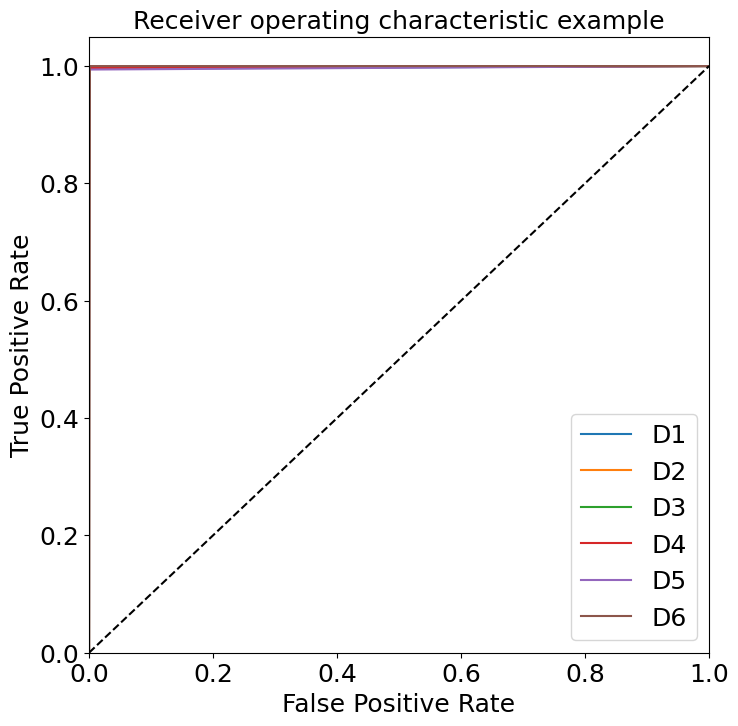

In [37]:
# Plot of a ROC curve for all classes
plt.figure(figsize=(8,8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Receiver operating characteristic example',fontsize=18)
plt.legend(cm_labels,loc="lower right",fontsize=18)

## Testing with dataTest

58/58 - 0s - 63ms/epoch - 1ms/step
58/58 - 0s - 58ms/epoch - 992us/step
Confusion matrix, without normalization
[[440  90  67  73  67  99]
 [ 17 172   4   2   2   3]
 [  3   7 164  21   2   3]
 [  2   0   6 181   8   3]
 [  7   0   2  15 159  17]
 [ 25   4   7  18  58  88]]


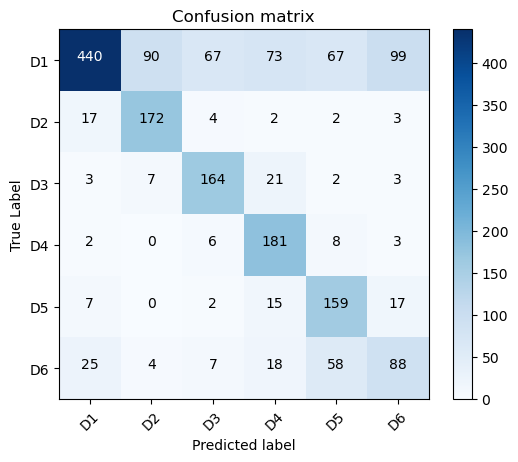

In [38]:
y_predicted0 = model.predict(X_test0, verbose = 2)
y_actual0 = y_test0

y_predict0 = model.predict(X_test0, verbose = 2)
y_predict0 = np.argmax(y_predict0, axis=1)

y_act0 = np.argmax(y_test0, axis=1)  # converting one hot representation back to numerical data

cm = confusion_matrix(y_act0, y_predict0)

# Plot Non-Normalized confusion matrix
cm_labels = ['D1','D2','D3','D4','D5','D6']
plot_confusion_matrix(cm, classes=cm_labels, title='Confusion matrix')

Normalized confusion matrix
[[0.53 0.11 0.08 0.09 0.08 0.12]
 [0.08 0.86 0.02 0.01 0.01 0.02]
 [0.02 0.04 0.82 0.1  0.01 0.02]
 [0.01 0.   0.03 0.9  0.04 0.02]
 [0.04 0.   0.01 0.08 0.8  0.08]
 [0.12 0.02 0.04 0.09 0.29 0.44]]


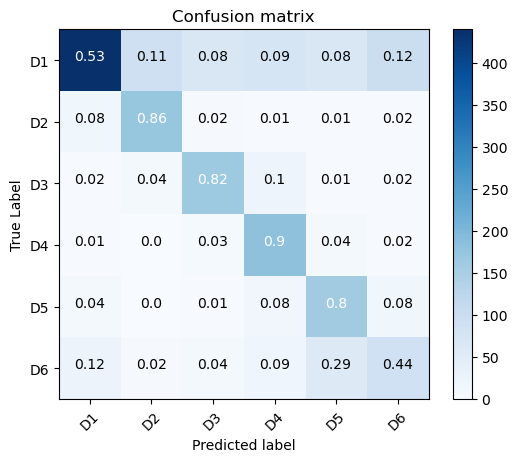

In [39]:
# Plot Normalized confusion matrix
plot_confusion_matrix(cm, classes=cm_labels, normalize = True, title='Confusion matrix')

In [40]:
# Classification Report
print('Classification Report:')
print(classification_report(y_act0, y_predict0, target_names = cm_labels))
#ATENCION: TIENE CAMBIADOS LOS LETREROS DE PRECISION Y RECALL, PRECISION ES EL SEGUNDO VALOR

Classification Report:
              precision    recall  f1-score   support

          D1       0.89      0.53      0.66       836
          D2       0.63      0.86      0.73       200
          D3       0.66      0.82      0.73       200
          D4       0.58      0.91      0.71       200
          D5       0.54      0.80      0.64       200
          D6       0.41      0.44      0.43       200

    accuracy                           0.66      1836
   macro avg       0.62      0.72      0.65      1836
weighted avg       0.71      0.66      0.65      1836



In [41]:
y_actual0=np.squeeze(y_actual0)

In [42]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

n_classes = 6
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds = roc_curve(y_actual0[:, i], np.round(y_predicted0[:,i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

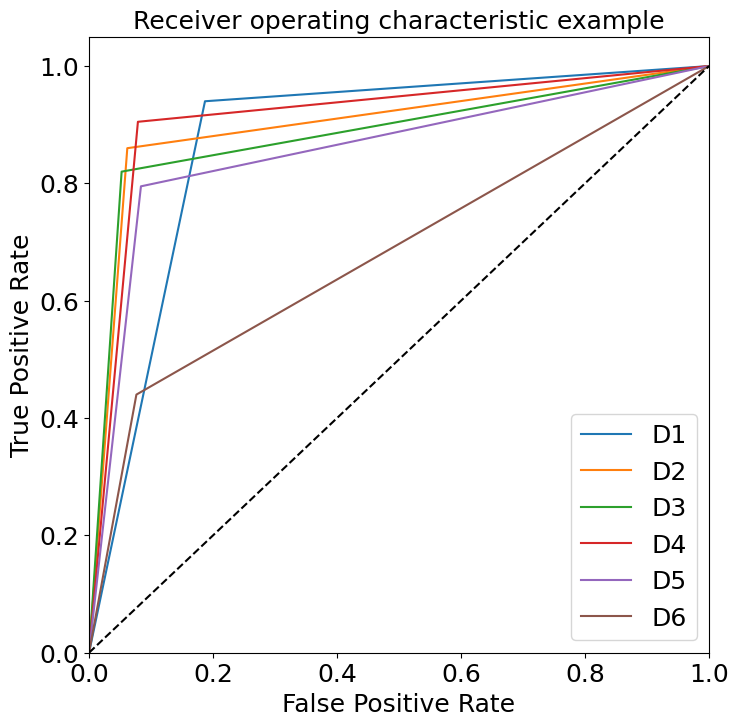

In [43]:
# Plot of a ROC curve for all classes
plt.figure(figsize=(8,8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], 'k--', label='reference')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Receiver operating characteristic example',fontsize=18)
plt.legend(cm_labels,loc="lower right",fontsize=18)
